# Neural Networks: Introduction

**Исполнители (ФИО):** Макеев Максим, Буканов Иван

---

Здравствуйте, классическое Машинное Обучение подошло к концу. Далее вы познакомитесь с Введением в Глубокое Обучение и научитесь работать с полносвязными нейронными сетями прямого распространенния

`В данном блокноте вы будете работать с библиотекой PyTorch, для комфортной работы и чтобы не тратить время на установку, воспользуйтесь сервисом Google Collab, в которой этот инструмент уже предустановлен`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Полносвязная нейронная сеть прямого распространения состоит из последовательных и связанным между собой слоев, каждый слой состоит из набора перцептронов (нейронов)

Перцептрон выражается формулой $f(\sum\limits_{i}w_{i}x_{i} + b)$, где $w_{i},b$ - веса, $x_{i}$ - входы, на первом слое - фичи, на последующих - выходы нейронов предыдущего слоя, $f$ - функция активации. Перцептрон является моделью линейной регрессии с нелинейной функцией активации

## Задача 1

Сгенерируйте данные $XOR$

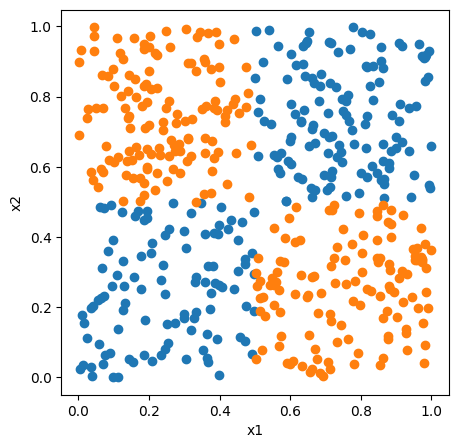

In [2]:
n_samples = 500
X = np.random.rand(n_samples, 2).astype(float)
y = ((X[:, 0] > 0.5) ^ (X[:, 1] > 0.5)).astype(float).reshape(-1, 1)

plt.figure(figsize=(5, 5))
mask0 = (y.ravel() == 0)
mask1 = (y.ravel() == 1)
plt.scatter(X[mask0, 0], X[mask0, 1])
plt.scatter(X[mask1, 0], X[mask1, 1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float().reshape(-1, 1)

X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test).float().reshape(-1, 1)

Создайте свой Перцептрон, используя пример ниже

In [3]:
# Пример Перцептрона

class Perceptron:

    def __init__(self, n_features, act):
        
        # инициализация весов и функции активации
        # requires_grad = True - для обучаемости весов (подсчета градиента)
        self.W = torch.normal(0, 0.1, (1, n_features), requires_grad = True)
        self.bias = torch.normal(0, 0.1, (1, 1), requires_grad = True)
        self.act = act

    def forward(self, x):
        
        # f(w* x + b)
        return self.act(torch.matmul(x, self.W.T) + self.bias)

    def parameters(self):
        return [self.W, self.bias]

In [4]:
n_features = X_train_t.shape[1]
perceptron = Perceptron(n_features=n_features, act=torch.sigmoid)

Чтобы обучить нейронную сеть, нужно 
1. посчитать предсказание
2. посчитать штраф (функцию потерь)
3. занулить градиент
4. посчитать градиент штрафа
5. сделать шаг градиентного спуска

In [5]:
criterion = nn.BCELoss()
n_epochs = 100
model = Perceptron(n_features=2, act=torch.sigmoid) 
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(n_epochs):
    y_pred_train = model.forward(X_train_t)
    loss_train = criterion(y_pred_train, y_train_t)
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    with torch.no_grad():
        y_train_cls = (y_pred_train >= 0.5).float()
        acc_train = (y_train_cls == y_train_t).float().mean().item()
        y_pred_test = model.forward(X_test_t)
        loss_test = criterion(y_pred_test, y_test_t)
        y_test_cls = (y_pred_test >= 0.5).float()
        acc_test = (y_test_cls == y_test_t).float().mean().item()
        
    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())
    train_accs.append(acc_train)
    test_accs.append(acc_test)

Если вы хотите использовать возможности видеокарты для обучения, необходимо перенести обучаемые веса и данные на *GPU* с помощью метода *.to(device)*

In [6]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

Обычно градиент вычисляется последовательно не от всех данных, а по кусочкам, которые называют *batch*

Обучите Перцептрон на ваших данных, сравните результат с логистической регрессией. Постройте кривую обучения Перцептрона (зависимость функции потерь и метрики от эпохи на тренировочных и валидационных данных)

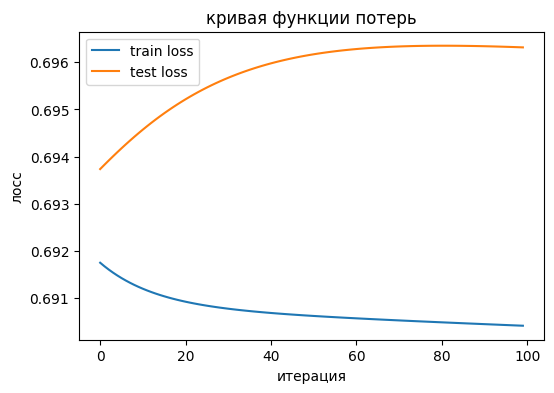

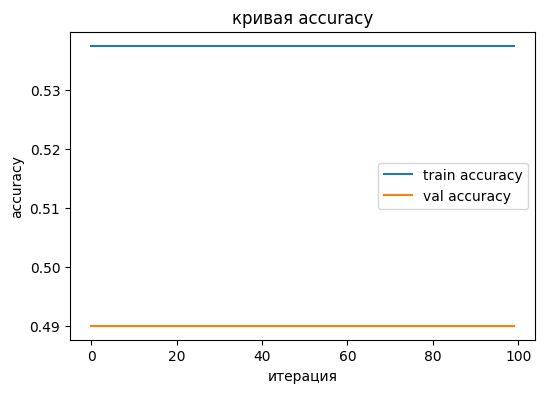

Perceptron:   train acc = 0.538, test acc = 0.490
LR: train acc = 0.588, test acc = 0.540


In [7]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('итерация')
plt.ylabel('лосс')
plt.title('кривая функции потерь')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='val accuracy')
plt.xlabel('итерация')
plt.ylabel('accuracy')
plt.title('кривая accuracy')
plt.legend()
plt.show()

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train.ravel())
y_train_lr = log_reg.predict(X_train)
y_test_lr = log_reg.predict(X_test)
acc_train_lr = accuracy_score(y_train.ravel(), y_train_lr)
acc_test_lr = accuracy_score(y_test.ravel(), y_test_lr)

print(f'Perceptron:   train acc = {train_accs[-1]:.3f}, test acc = {test_accs[-1]:.3f}')
print(f'LR: train acc = {acc_train_lr:.3f}, test acc = {acc_test_lr:.3f}')

Теперь попробуйте взять несколько перцептронов с разными начальными весами и собрать их в один слой (для измените класс *Perceptron*, чтобы он содержал несколько нейронов) 

Подумайте как аггрегировать вместе предсказания нескольких нейронов (слоя)

In [8]:
class PerceptronMod:
    
    def __init__(self, n_features, n_neurons, act_hidden=torch.tanh, act_out=torch.sigmoid):
        self.W = torch.normal(0, 0.1, (n_neurons, n_features), requires_grad=True)
        self.bias = torch.normal(0, 0.1, (n_neurons,), requires_grad=True)
        self.v = torch.normal(0, 0.1, (1, n_neurons), requires_grad=True)
        self.c = torch.normal(0, 0.1, (1, 1), requires_grad=True)
        self.act_hidden = act_hidden
        self.act_out = act_out

    def forward(self, x):
        h_lin = x @ self.W.T + self.bias          
        h = self.act_hidden(h_lin)              
        y_lin = h @ self.v.T + self.c      
        y = self.act_out(y_lin)               
        return y

    def parameters(self):
        return [self.W, self.bias, self.v, self.c]

In [9]:
criterion = nn.BCELoss()
n_epochs = 200

n_hidden = 10
model = PerceptronMod(n_features=n_features, n_neurons=n_hidden,
                        act_hidden=torch.tanh, act_out=torch.sigmoid)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(n_epochs):
    y_pred_train = model.forward(X_train_t)
    loss_train = criterion(y_pred_train, y_train_t)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    with torch.no_grad():
        y_train_cls = (y_pred_train >= 0.5).float()
        acc_train = (y_train_cls == y_train_t).float().mean().item()

        y_pred_test = model.forward(X_test_t)
        loss_test = criterion(y_pred_test, y_test_t)
        y_test_cls = (y_pred_test >= 0.5).float()
        acc_test = (y_test_cls == y_test_t).float().mean().item()

    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())
    train_accs.append(acc_train)
    test_accs.append(acc_test)


Сравните Перцептрон, Логистическую Регрессиию и Слой Перцептронов

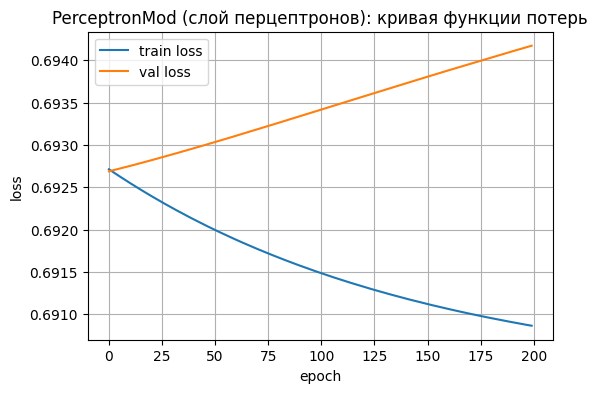

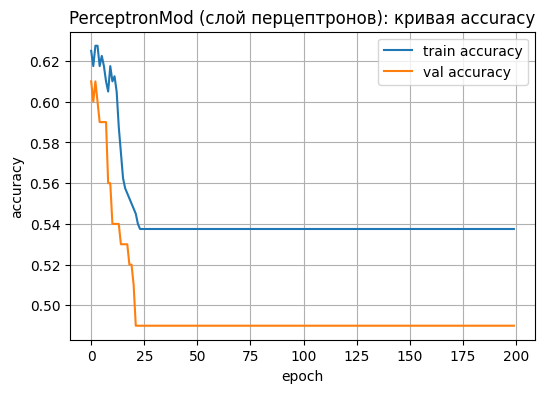

слой перцептронов — train acc = 0.538, test acc = 0.490


In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('PerceptronMod (слой перцептронов): кривая функции потерь')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('PerceptronMod (слой перцептронов): кривая accuracy')
plt.legend()
plt.grid(True)
plt.show()

print(f'слой перцептронов — train acc = {train_accs[-1]:.3f}, test acc = {test_accs[-1]:.3f}')

**Вопрос:** Какая модель оказалась лучше? Есть ли различие в их работе? Предположите, почему?

примерно все оказались равны по качеству очев логрег и один нейрон не справились с нелинейным хором а слой мб криво настроил (хотя я пытался варировать число нейронов и эпох)

## Задача 2

In [82]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.flatten = nn.Flatten()

        # n_i количество перцептронов на i слое
        # соответствует количеству входов на i + 1 слое
        self.layers_stack = nn.Sequential(
            nn.Linear(n_features, n1),
            nn.ReLU(), # функция активации после первого слоя
            nn.Linear(n1, n2),
            nn.ReLU(), # функция активации после второго слоя
            nn.Linear(n2, n_classes)
        )

    def forward(self, x):
        x = self.flatten(x) # делаем данные плоскоми
        logits = self.layers_stack(x) # применяем последовательно слои
        return logits

Загрузите датасет *richters_whole_1.csv*

In [83]:
df = pd.read_csv("richters_whole_1.csv")
df = df.drop(columns=["Unnamed: 0"])
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
y_raw = df["damage_grade"].values
X2 = df.drop(columns=cat_cols + ["damage_grade"]).astype("float32").values
classes, y_encoded = np.unique(y_raw, return_inverse=True)
y2 = y_encoded.astype(np.int64)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2,test_size=0.3,random_state=42,stratify=y2)

Постройте полносвязную нейронную сеть, используя пример выше, для классификации на ваших данных

Epoch 10/500, train loss = 792.0283, test loss = 188.6726, train acc = 0.566, test acc = 0.561
Epoch 20/500, train loss = 1360.0806, test loss = 1141.4296, train acc = 0.568, test acc = 0.566
Epoch 30/500, train loss = 780.0128, test loss = 521.0618, train acc = 0.568, test acc = 0.567
Epoch 40/500, train loss = 272.2390, test loss = 134.1781, train acc = 0.567, test acc = 0.562
Epoch 50/500, train loss = 252.0132, test loss = 100.0615, train acc = 0.367, test acc = 0.451
Epoch 60/500, train loss = 160.2354, test loss = 80.4824, train acc = 0.560, test acc = 0.376
Epoch 70/500, train loss = 145.6376, test loss = 283.9085, train acc = 0.417, test acc = 0.562
Epoch 80/500, train loss = 82.3054, test loss = 442.0173, train acc = 0.549, test acc = 0.314
Epoch 90/500, train loss = 327.1166, test loss = 199.1655, train acc = 0.354, test acc = 0.514
Epoch 100/500, train loss = 98.5186, test loss = 80.0710, train acc = 0.485, test acc = 0.473
Epoch 110/500, train loss = 110.3437, test loss = 2

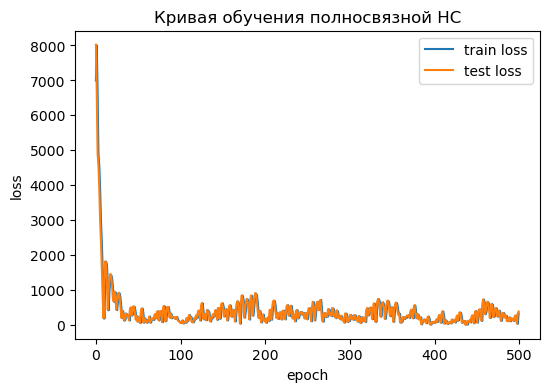

In [84]:
n_features = X2_train.shape[1]
n1 = 64
n2 = 32
n_classes = len(np.unique(y2_train))

model2 = NeuralNetwork().to(device)

criterion2 = nn.CrossEntropyLoss().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

n_epochs2 = 500

X2_train_t = torch.from_numpy(X2_train).to(device)
y2_train_t = torch.from_numpy(y2_train).to(device)

X2_test_t = torch.from_numpy(X2_test).to(device)
y2_test_t = torch.from_numpy(y2_test).to(device)

train_losses2 = []
test_losses2 = []

for epoch in range(n_epochs2):
    logits_train = model2(X2_train_t)
    loss_train = criterion2(logits_train, y2_train_t)

    optimizer2.zero_grad()
    loss_train.backward()
    optimizer2.step()

    with torch.no_grad():
        logits_test = model2(X2_test_t)
        loss_test = criterion2(logits_test, y2_test_t)

    train_losses2.append(loss_train.item())
    test_losses2.append(loss_test.item())

    if (epoch + 1) % 10 == 0:
        _, train_pred = torch.max(logits_train, 1)
        _, test_pred = torch.max(logits_test, 1)
        train_acc = (train_pred == y2_train_t).float().mean().item()
        test_acc = (test_pred == y2_test_t).float().mean().item()

        print(f"Epoch {epoch+1}/{n_epochs2}, "
              f"train loss = {loss_train.item():.4f}, "
              f"test loss = {loss_test.item():.4f}, "
              f"train acc = {train_acc:.3f}, "
              f"test acc = {test_acc:.3f}")

plt.figure(figsize=(6, 4))
plt.plot(train_losses2, label="train loss")
plt.plot(test_losses2, label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Кривая обучения полносвязной НС")
plt.legend()
plt.show()


Попробуйте разные архитектуры нейронной сети, произвольно меняя параметры: 
1. количество слоев
2. количество перцептронов в слое
3. функции активации слоя

Постройте кривую обучения Нейронной сети (зависимость функции потерь и метрики от эпохи на тренировочных и валидационных данных)

[ALT] Epoch 10/500, train loss = 427.9593, test loss = 858.8077, train acc = 0.569, test acc = 0.335
[ALT] Epoch 20/500, train loss = 432.2668, test loss = 128.2803, train acc = 0.568, test acc = 0.336
[ALT] Epoch 30/500, train loss = 604.7523, test loss = 741.4979, train acc = 0.335, test acc = 0.335
[ALT] Epoch 40/500, train loss = 494.4407, test loss = 272.0890, train acc = 0.568, test acc = 0.125
[ALT] Epoch 50/500, train loss = 307.6215, test loss = 527.0543, train acc = 0.567, test acc = 0.335
[ALT] Epoch 60/500, train loss = 701.2162, test loss = 333.6898, train acc = 0.097, test acc = 0.562
[ALT] Epoch 70/500, train loss = 289.1647, test loss = 225.0596, train acc = 0.567, test acc = 0.336
[ALT] Epoch 80/500, train loss = 241.7147, test loss = 213.0466, train acc = 0.568, test acc = 0.568
[ALT] Epoch 90/500, train loss = 184.5358, test loss = 150.4916, train acc = 0.336, test acc = 0.567
[ALT] Epoch 100/500, train loss = 84.4165, test loss = 45.2715, train acc = 0.336, test acc

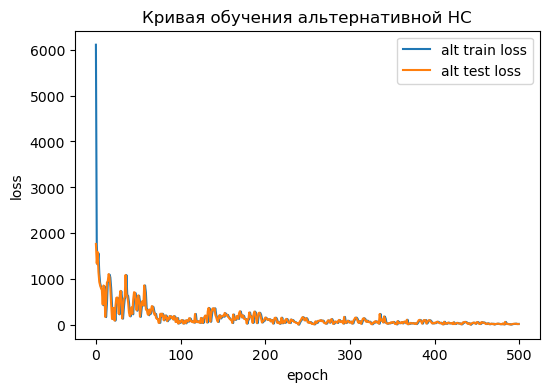

In [85]:
class NeuralNetworkAlt(nn.Module):
    def __init__(self, n_features, n1, n2, n3, n_classes, act_hidden):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(n_features, n1),
            act_hidden,
            nn.Linear(n1, n2),
            act_hidden,
            nn.Linear(n2, n3),
            act_hidden,
            nn.Linear(n3, n_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layers_stack(x)

n1_alt = 256
n2_alt = 128
n3_alt = 65
act_alt = nn.LeakyReLU(negative_slope=0.01)

model_alt = NeuralNetworkAlt(n_features, n1_alt, n2_alt, n3_alt, n_classes, act_alt).to(device)

criterion_alt = nn.CrossEntropyLoss().to(device)
optimizer_alt = torch.optim.Adam(model_alt.parameters(), lr=0.001)

n_epochs_alt = 500

train_losses_alt = []
test_losses_alt = []

for epoch in range(n_epochs_alt):
    logits_train_alt = model_alt(X2_train_t)
    loss_train_alt = criterion_alt(logits_train_alt, y2_train_t)

    optimizer_alt.zero_grad()
    loss_train_alt.backward()
    optimizer_alt.step()

    with torch.no_grad():
        logits_test_alt = model_alt(X2_test_t)
        loss_test_alt = criterion_alt(logits_test_alt, y2_test_t)

    train_losses_alt.append(loss_train_alt.item())
    test_losses_alt.append(loss_test_alt.item())

    if (epoch + 1) % 10 == 0:
        _, train_pred_alt = torch.max(logits_train_alt, 1)
        _, test_pred_alt = torch.max(logits_test_alt, 1)
        train_acc_alt = (train_pred_alt == y2_train_t).float().mean().item()
        test_acc_alt = (test_pred_alt == y2_test_t).float().mean().item()

        print(f"[ALT] Epoch {epoch+1}/{n_epochs_alt}, "
              f"train loss = {loss_train_alt.item():.4f}, "
              f"test loss = {loss_test_alt.item():.4f}, "
              f"train acc = {train_acc_alt:.3f}, "
              f"test acc = {test_acc_alt:.3f}")

with torch.no_grad():
    logits_test_alt = model_alt(X2_test_t)
    _, y2_pred_alt = torch.max(logits_test_alt, 1)
    acc_alt = (y2_pred_alt == y2_test_t).float().mean().item()

print(f"\nAccuracy для альтернативной архитектуры: {acc_alt:.3f}")

plt.figure(figsize=(6, 4))
plt.plot(train_losses_alt, label="alt train loss")
plt.plot(test_losses_alt, label="alt test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Кривая обучения альтернативной НС")
plt.legend()
plt.show()

**Вопрос:** Какая архитектура нейронной сети оказалась наилучшей для решения данной задачи?

я бы не сказал, что одна архитектура прям явно выигрывает они +- примерно на одном уровне вторая обучается чуть лучше как видно по графику но нет прироста в качестве 

## Задача 3

Для удобного деления данных на батчи используйте *torch.utils.data.DataLoader* 

Это необходимо, поскольку зачастую невозможно все данные поместить на *GPU*

*batch_size* ограничен сверху оперативной паматью видеокарты, а снизу - тем, что тем меньше взять данных в батч, тем хуже будет обучение весов

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size, shuffle = False)

Загрузите датасет [МNIST](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)

In [ ]:
#Your code here

Постройте нейросеть и обучите её с разбиением на батчи. Постарайтесь добиться качества около 95%

In [ ]:
#Your code

**Вопрос:** Какую архитектуру подобрали и на сколько батчей разбивали данные?

*Your answer here*

## Задача 4

Важным математическим результатом теории нейросетей является [Теорема Цыбенко](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%A6%D1%8B%D0%B1%D0%B5%D0%BD%D0%BA%D0%BE), которая гласит, что для любой непрерывной функции можно подобрать веса нейросети с одним скрытым слоем и сигмоидальной функцией активации таким образом, чтобы сколько угодно точно приблизить её

В файле *signal_sample_1.csv* содержатся данные о физическом сигнале $X(t)$. Проверьте теорему Цыбенко на этих данных

In [ ]:
#Your code here

Визуализируйте сигнал и подобранную нейросетью функцию

In [ ]:
#Your code here

**Вопрос:** С какой точностью получилось восстановить функцию сигнала?

*Your answer here*